In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from seaborn import lmplot, stripplot, scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix

<h1>Read in and Check the Data</h1>

In [3]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("../datasets/dataset_salaries.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [4]:
df.shape

(62642, 17)

In [5]:
df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,11/3/2020 10:26:30,Microsoft,60,Data Scientist,181,"Redmond, WA",1,1,ML / AI,104,47,30,Male,mckeiaps hash ghaart gronds wuit zearts tsiott...,11521,819.0,47529
1,8/14/2018 21:08:29,VMware,Senior MTS,Software Engineer,0,"Palo Alto, CA",5,3,Full Stack,0,0,0,NaN,NaN,7351,807.0,1418
2,5/18/2019 0:32:17,Paypal,T25,Software Engineer,213,"San Francisco, CA",7,1,API Development (Back-End),180,19,14,Male,NaN,7419,807.0,8815
3,8/3/2021 20:25:07,Trend Micro,Senior Engineer,Software Engineer,18,"Taipei, TP, Taiwan",2,2,Distributed Systems (Back-End),14,1,3,Male,mcclieusp hyoully preebly gloiands screoch sch...,6744,0.0,81297
4,5/3/2021 15:25:42,Visa,Senior Software Engineer,Software Engineer,179,"Austin, TX",3,0,Full Stack,158,9,12,Female,dyniawn cauny spliur cleals crungs kwoiw thrai...,10965,635.0,68303


In [6]:
df.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber'],
      dtype='object')

<h1>Justification for feature selection</h1> 
<ul>
    <li>Columns such as cityid, dmaid and rowNumber are not useful to be features, so I dropped them. Same as with otherdetails, which appear to be gibberish.</li>

<li>On inspection, the totalyearlycompensation is the sum of the basesalary, stockgrantvalue and bonus. Since basesalary is the value we are predicting, including totalyearlycompensation as a feature would be a form of leakage, allowing the model to directly compute the basesalary by subtracting the bonus and stockgrantvalue from the totalyearlycompensation.</li>

<li>I decided to include both the bonus and stockgrantvalue as features, as I hypothesise that the amount of bonus an employee receives may signal that they are performing well, which in turn could be correlated with a higher base salary. Similarly, the stockgrantvalue is also included as I believe that having higher stockgrantvalues might be associated with higher base salaries, as it could indicate that the company is doing good financially.</li>

<li>The timestamp is also included as a feature, as the base salary might vary depending on the month and year.</li>

<li>The other features, such as company, level, title, yearsofexperience, yearsatcompany, tag and gender all seem like important factors to consider for an employee's base salary. Thus,they are included as features.</li>
</ul>

In [7]:
features = ['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag',
       'stockgrantvalue', 'bonus', 'gender']

In [8]:
nominal_features = ['company', 'level', 'title', 'location', 'tag', 'gender']

In [9]:
numeric_features = ['timestamp', 'yearsofexperience', 'yearsatcompany', 'stockgrantvalue', 'bonus']

<p>
    Inspect the data and determine whether there is any cleaning needed.
</p>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62527 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  int64  
 7   yearsatcompany           62642 non-null  int64  
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  int64  
 10  stockgrantvalue          62642 non-null  int64  
 11  bonus                    62642 non-null  int64  
 12  gender                   43102 non-null  object 
 13  otherdetails             40139 non-null  object 
 14  cityid                

In [11]:
for feature in nominal_features:
    print(feature, df[feature].unique())

company ['Microsoft' 'VMware' 'Paypal' ... 'World wide technology '
 'cadence design systems' '\xa0Google']
level ['60' 'Senior MTS' 'T25' ... 'Lead software engineer ' 'Senior L1'
 'Level 26']
title ['Data Scientist' 'Software Engineer' 'Management Consultant' 'Marketing'
 'Hardware Engineer' 'Human Resources' 'Product Manager'
 'Business Analyst' 'Product Designer' 'Software Engineering Manager'
 'Recruiter' 'Solution Architect' 'Technical Program Manager'
 'Mechanical Engineer' 'Sales']
location ['Redmond, WA' 'Palo Alto, CA' 'San Francisco, CA' ...
 'Mandaluyong City, MM, Philippines' 'Angeles City, PM, Philippines'
 'Pasir Ris, SG, Singapore']
tag ['ML / AI' 'Full Stack' 'API Development (Back-End)' ... 'Hardware Apps'
 'Creative Shop' 'Eng Ops']
gender ['Male' nan 'Female' 'Other' 'Title: Senior Software Engineer']


In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
# Converts numeric features to float instead of int
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)

In [14]:
# Extract the features but leave as a DataFrame
X = df[features]

# Target values, converted to a 1D numpy array
y = df['basesalary']

In [15]:
df = df[['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag',
       'stockgrantvalue', 'bonus', 'gender', 'basesalary']]

Replace all empty values with NaNs, to be treated later:

In [16]:
df.replace("", np.nan)

,timestamp,company,level,title,location,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,basesalary
0,1604399190000000000,Microsoft,60,Data Scientist,"Redmond, WA",1,1,ML / AI,47,30,Male,104
1,1534280909000000000,VMware,Senior MTS,Software Engineer,"Palo Alto, CA",5,3,Full Stack,0,0,NaN,0
2,1558139537000000000,Paypal,T25,Software Engineer,"San Francisco, CA",7,1,API Development (Back-End),19,14,Male,180
3,1628022307000000000,Trend Micro,Senior Engineer,Software Engineer,"Taipei, TP, Taiwan",2,2,Distributed Systems (Back-End),1,3,Male,14
4,1620055542000000000,Visa,Senior Software Engineer,Software Engineer,"Austin, TX",3,0,Full Stack,9,12,Female,158
...,...,...,...,...,...,...,...,...,...,...,...,...
62637,1614780885000000000,Nvidia,IC4,Hardware Engineer,"Santa Clara, CA",9,3,Verification,145,0,Male,170
62638,1599727981000000000,Qualcomm,Principal Engineer,Hardware Engineer,"Austin, TX",15,13,ASIC Design,87,41,Male,114
62639,1555939086000000000,Microsoft,61,Software Engineer,"Redmond, WA",6,1,Full Stack,4,7,Male,72
62640,1604433418000000000,Google,L3,Business Analyst,"Tokyo, TY, Japan",3,1,Technical,12,7,Male,88


In [17]:
df.describe(datetime_is_numeric=True, include="all")

,timestamp,company,level,title,location,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,basesalary
count,6.264200e+04,62637,62527,62642,62642,62642.000000,62642.000000,61788,6.264200e+04,62642.000000,43102,6.264200e+04
unique,NaN,1869,3071,15,1050,NaN,NaN,3271,NaN,NaN,4,NaN
top,NaN,Amazon,L4,Software Engineer,"Seattle, WA",NaN,NaN,Full Stack,NaN,NaN,Male,NaN
freq,NaN,8054,5008,41231,8701,NaN,NaN,11382,NaN,NaN,35702,NaN
mean,1.594957e+18,NaN,NaN,NaN,NaN,7.191054,2.700616,NaN,1.134865e+03,242.317199,NaN,1.798145e+03
std,2.653088e+16,NaN,NaN,NaN,NaN,6.437148,3.524030,NaN,2.520611e+04,3709.187697,NaN,1.927194e+04
min,1.496835e+18,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00,0.000000,NaN,0.000000e+00
25%,1.578784e+18,NaN,NaN,NaN,NaN,3.000000,0.000000,NaN,0.000000e+00,1.000000,NaN,8.800000e+01
50%,1.600706e+18,NaN,NaN,NaN,NaN,6.000000,1.000000,NaN,2.300000e+01,13.000000,NaN,1.310000e+02
75%,1.616772e+18,NaN,NaN,NaN,NaN,10.000000,4.000000,NaN,6.400000e+01,27.000000,NaN,1.810000e+02


<h1>Create a Test Set</h1>

The datasets are split into 80% development set (comprising of 60% training and 20% validation sets) and 20% test set for validation and testing error estimations respectively.

I am doing holdouts rather than the k-Fold Cross Validations given that a dataset with a few thousand rows is considered large.

In [18]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

In [19]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

In [20]:
# Target values, converted to a 1D numpy array
dev_y = dev_df["basesalary"].values
test_y = test_df["basesalary"].values

The development data set is further split into the training and validation set (60% and 20% of original dataset) via a holdout, such that we can compare the training and validation errors later on to determine if the model is underfitting/overfitting:

In [21]:
# Split off the validation set: 20% of the entire dataset.
# Since the remaining training set is 60% of entire dataset, that is equal to 75% of the development dataset
# Create the object that shuffles and splits the dev data
ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)
ss

ShuffleSplit(n_splits=1, random_state=2, test_size=None, train_size=0.75)

<h1>Dataset Exploration</h1>

In [22]:
# A copy of the training set is made
copy_df = dev_df.copy()

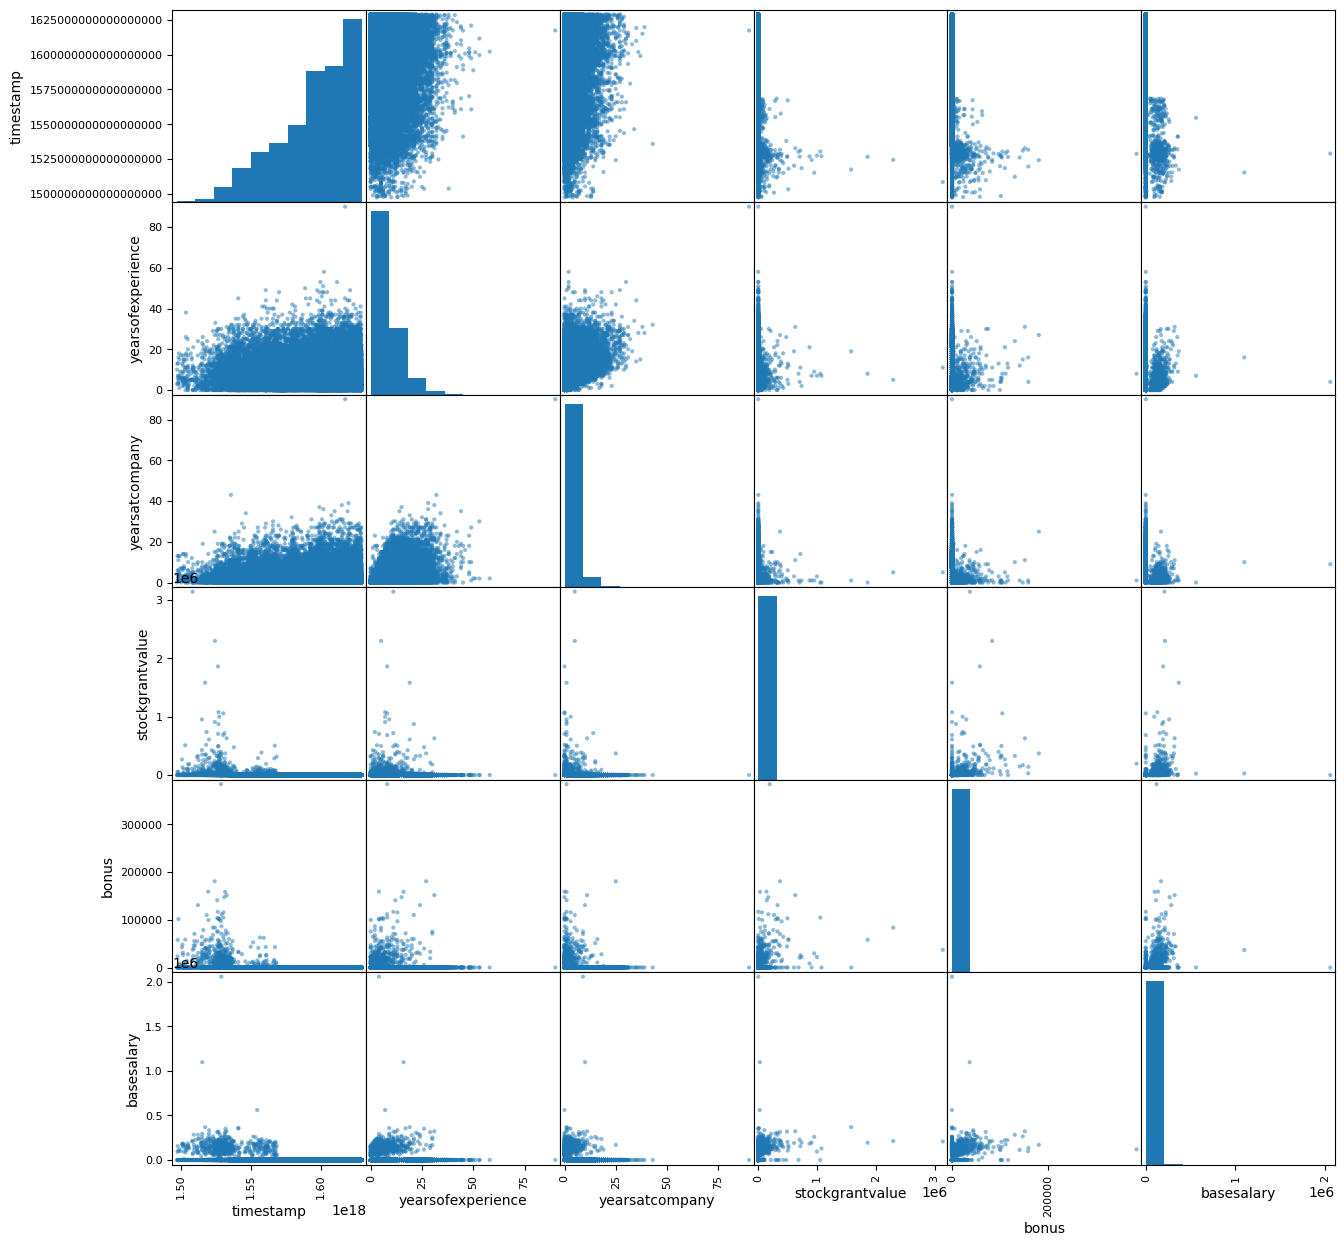

In [23]:
m = scatter_matrix(copy_df, figsize=(15, 15))

<AxesSubplot: >

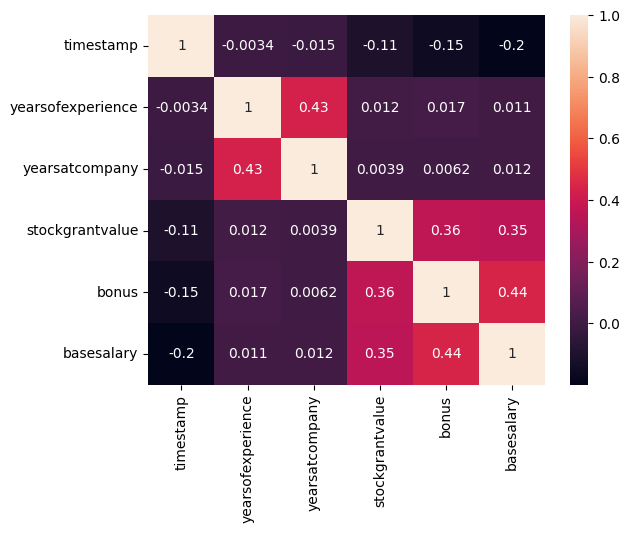

In [24]:
heatmap(copy_df.corr(numeric_only=True), annot=True)

In [25]:
preprocessor = ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                        ("scaler", StandardScaler())]), numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                        ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), nominal_features)],
        remainder="passthrough")

In [26]:
def build_model(model, additional_params={}):
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", model)])

    model_param_grid = {
#         "preprocessor__num__uwr__insert": [True, False],
#         "preprocessor__num__units_elapsed__insert": [True, False],
    }
    
    model_param_grid.update(additional_params)

    model_gs = GridSearchCV(model, model_param_grid, scoring="neg_mean_absolute_error", cv=ss, refit=True)

    model_gs.fit(dev_X, dev_y)

    print(model_gs.best_params_, model_gs.best_score_)
    
    return model_gs

In [27]:
# scaling wouldn't do any harm
linear_gs = build_model(LinearRegression())

{} -4381.741675268077


In [ ]:
# Run takes shorter time if I limit it to 6
knn_gs = build_model(KNeighborsRegressor(), additional_params={"predictor__n_neighbors": [x for x in range(4, 6)]})

In [ ]:
cross_val_score(knn_gs, X, y, scoring="neg_mean_absolute_error", cv=10)